## Importations

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

#Importing SMOTE for data balancing
from imblearn.over_sampling import SMOTE


from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Hyperparameters Fine-tuning (Scikit-learn hp search, cross-validation, etc. )
from sklearn.model_selection import GridSearchCV

## Data Loading

In [28]:
train_df = pd.read_csv('clean_train.csv')
test_df = pd.read_csv('clean_test.csv')

# Convert the dataframe to a GeoDataFrame
train_gdf = gpd.GeoDataFrame(
    train_df
)
test_gdf = gpd.GeoDataFrame(
    test_df

)

In [29]:
train_gdf.head()

,subid,lat,lon,bcount,x,y,bd20,bio1,bio12,bio7,...,npps,ph20,sirm,sirs,slope,snd20,soc20,tim,landcover,landcover_encoded
0,1548937,7.387687,-4.780390,0.0,-2.714375e+06,321874.969864,1.4900,262,1006,58,...,853.451416,6.100,0.717054,0.008259,0.729217,66.75,12.25,8.079082,woody,2
1,1548936,8.690266,-5.770243,0.0,-2.812625e+06,474124.973063,1.2925,257,1118,70,...,933.074402,5.575,0.717198,0.007242,1.086981,51.50,14.25,9.549431,cropland,1
2,1548935,8.518763,-2.808147,0.0,-2.495125e+06,440374.986977,1.3050,265,930,66,...,1186.817627,5.850,0.717171,0.006744,1.159993,47.00,14.50,10.523131,cropland,1
3,1548934,8.637725,-3.048867,0.0,-2.520375e+06,454875.008083,1.3275,263,875,67,...,910.979309,5.950,0.718244,0.007917,2.471163,62.75,12.75,9.305363,cropland,1
4,1548933,7.993474,-6.044227,0.0,-2.846625e+06,396624.944149,1.4200,260,1073,60,...,802.602661,5.800,0.716653,0.007022,0.259416,55.00,13.25,15.732859,cropland,1


In [30]:
test_gdf.head()

,subid,lat,lon,bcount,x,y,bd20,bio1,bio12,bio7,...,mdem,nppm,npps,ph20,sirm,sirs,slope,snd20,soc20,tim
0,1548905,4.824505,-7.522892,NaN,-3.023125e+06,44125.021587,1.4075,250,2564,46,...,118,12909.700195,870.217346,5.025,0.719068,0.007398,4.093175,64.50,23.50,9.168183
1,1548829,5.457730,-5.010404,NaN,-2.749125e+06,104624.973824,1.6350,261,1378,71,...,37,12288.299805,839.143616,4.850,0.724049,0.007270,0.487844,65.75,13.00,7.896024
2,1548811,5.081743,-7.148626,NaN,-2.981625e+06,71625.015246,1.5825,247,1704,46,...,220,13374.500000,763.726135,5.100,0.720274,0.006467,2.113945,52.00,23.25,7.606022
3,1548806,5.673164,-4.171414,NaN,-2.657375e+06,125374.968207,1.7350,261,1700,68,...,49,11717.200195,814.182434,5.125,0.724026,0.007111,0.962922,59.75,15.00,8.471351
4,1548798,4.665885,-7.040600,NaN,-2.971875e+06,23875.013622,1.5925,259,1724,61,...,23,3474.800049,1809.494385,4.950,0.716632,0.007030,0.779259,70.50,15.75,13.725027


In [31]:
train_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 15811 entries, 0 to 15810
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subid              15811 non-null  int64  
 1   lat                15811 non-null  float64
 2   lon                15811 non-null  float64
 3   bcount             15811 non-null  float64
 4   x                  15811 non-null  float64
 5   y                  15811 non-null  float64
 6   bd20               15811 non-null  float64
 7   bio1               15811 non-null  int64  
 8   bio12              15811 non-null  int64  
 9   bio7               15811 non-null  int64  
 10  bio15              15811 non-null  int64  
 11  cec20              15811 non-null  float64
 12  dipa               15811 non-null  float64
 13  dni                15811 non-null  float64
 14  dnlt               15811 non-null  float64
 15  dnpa               15811 non-null  float64
 16  dor1          

In [32]:
# Drop the original 'landcover' column (the object version)
train_gdf = train_gdf.drop(columns=['landcover'])

# Rename 'landcover_encoded' to 'landcover'
train_gdf = train_gdf.rename(columns={'landcover_encoded': 'landcover'})



In [33]:
train_gdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15811 entries, 0 to 15810
Data columns (total 45 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   subid      15811 non-null  int64  
 1   lat        15811 non-null  float64
 2   lon        15811 non-null  float64
 3   bcount     15811 non-null  float64
 4   x          15811 non-null  float64
 5   y          15811 non-null  float64
 6   bd20       15811 non-null  float64
 7   bio1       15811 non-null  int64  
 8   bio12      15811 non-null  int64  
 9   bio7       15811 non-null  int64  
 10  bio15      15811 non-null  int64  
 11  cec20      15811 non-null  float64
 12  dipa       15811 non-null  float64
 13  dni        15811 non-null  float64
 14  dnlt       15811 non-null  float64
 15  dnpa       15811 non-null  float64
 16  dor1       15811 non-null  float64
 17  dor2       15811 non-null  float64
 18  fpara      15811 non-null  float64
 19  fpars      15811 non-null  float64
 20  lcc10 

## Splitting the Dataset into Features and Target Variable

In [34]:
X = train_gdf.drop(columns=['subid', 'landcover'])
y = train_gdf['landcover']

In [35]:
X.head()

,lat,lon,bcount,x,y,bd20,bio1,bio12,bio7,bio15,...,mdem,nppm,npps,ph20,sirm,sirs,slope,snd20,soc20,tim
0,7.387687,-4.780390,0.0,-2.714375e+06,321874.969864,1.4900,262,1006,58,128,...,199,5052.299805,853.451416,6.100,0.717054,0.008259,0.729217,66.75,12.25,8.079082
1,8.690266,-5.770243,0.0,-2.812625e+06,474124.973063,1.2925,257,1118,70,162,...,362,5316.700195,933.074402,5.575,0.717198,0.007242,1.086981,51.50,14.25,9.549431
2,8.518763,-2.808147,0.0,-2.495125e+06,440374.986977,1.3050,265,930,66,154,...,288,4519.700195,1186.817627,5.850,0.717171,0.006744,1.159993,47.00,14.50,10.523131
3,8.637725,-3.048867,0.0,-2.520375e+06,454875.008083,1.3275,263,875,67,156,...,320,3439.800049,910.979309,5.950,0.718244,0.007917,2.471163,62.75,12.75,9.305363
4,7.993474,-6.044227,0.0,-2.846625e+06,396624.944149,1.4200,260,1073,60,146,...,265,5226.899902,802.602661,5.800,0.716653,0.007022,0.259416,55.00,13.25,15.732859


In [36]:
y.head()

,landcover
0,2
1,1
2,1
3,1
4,1


## Data Spitting

In [37]:
from sklearn.model_selection import train_test_split
# Split the data into training and evaluation sets
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [38]:
X_train.shape, X_eval.shape, y_train.shape, y_eval.shape


((12648, 43), (3163, 43), (12648,), (3163,))

## Data Scaling

In [39]:
from sklearn.preprocessing import StandardScaler

#Cloning the standardscaler class
scaler =StandardScaler().set_output(transform="pandas")

#Fitting and transforming the selected columns in the training data set
X_train_scaled = X_train.copy()
X_train_scaled=scaler.fit_transform(X_train)

#Transforming the selected columns  in the evaluation dataset
X_eval_scaled=X_eval.copy()
X_eval_scaled = scaler.transform(X_eval)

In [40]:
X_train_scaled.head()

,lat,lon,bcount,x,y,bd20,bio1,bio12,bio7,bio15,...,mdem,nppm,npps,ph20,sirm,sirs,slope,snd20,soc20,tim
4748,-1.064645,-0.355011,-0.138254,-0.416325,-1.049024,0.334173,-0.893642,0.657599,-1.427674,-0.905092,...,-0.450011,0.409156,-2.292061,0.618189,0.126979,1.164402,-0.446802,0.523376,0.048235,0.727310
57,1.505847,-1.417594,-0.138254,-1.318869,1.571992,-1.399952,0.015246,0.247609,2.120760,1.580276,...,1.155479,-0.926625,-0.552530,0.037078,0.097044,-0.561604,-0.011421,-2.219531,-0.502208,-0.434783
11200,0.143553,-0.848583,-0.138254,-0.845073,0.180791,-1.215797,-0.439198,0.271262,-0.219697,0.365835,...,0.409494,0.559630,0.636649,0.981385,0.095886,-0.570367,-0.683128,-1.019509,0.094105,0.825519
9030,0.399609,1.277745,-0.138254,1.295557,0.342177,-0.387101,0.621172,-0.659101,-0.370694,0.394078,...,-0.068910,-0.175019,0.307333,1.126663,0.035358,-0.504388,-0.008357,1.003385,0.139975,0.044575
5388,-1.207918,1.041463,-0.138254,0.980210,-1.247768,0.855945,0.166728,1.075474,-0.446193,-1.413463,...,-1.585206,1.656435,0.328103,-1.706259,0.110011,0.876726,-0.628777,0.386231,0.277586,-0.569101


## Handling Imbalance in the Rarget Variable
The basic idea behind SMOTE is to create new minority class samples by randomly selecting one or more of the k-nearest neighbors of each minority class sample, and using them to create new synthetic samples (Nababan et al., 2023).


In [41]:
from imblearn.over_sampling import SMOTE
print("Original class distribution:")
print(y_train.value_counts())

#Cloning the class SMOTE and specifying the sampling strategy
smote = SMOTE(random_state=32)
X_resampled, y_resampled= smote.fit_resample(X_train_scaled, y_train)

# Check the distribution after after resampling
y_resampled.value_counts()

Original class distribution:
landcover
2    6009
1    5593
0    1046
Name: count, dtype: int64


,count
landcover,
1,6009
2,6009
0,6009


## Model Training

In [42]:
# Define models to evaluate
models = [
    ('Random Forest', RandomForestClassifier(random_state=42, class_weight='balanced')),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, class_weight='balanced')),
    ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')),
]


In [43]:
# Initialize an empty dataframe for the results
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'])

# Iterate over the models and evaluate
for model_name, model in models:
    # Fit the model on the resampled training data
    model.fit(X_resampled, y_resampled)

    # Make predictions on the evaluation set
    y_pred = model.predict(X_eval_scaled)

    # Get predicted probabilities for ROC-AUC
    y_pred_proba = model.predict_proba(X_eval_scaled)

    # Calculate evaluation metrics with multi-class averaging
    accuracy = accuracy_score(y_eval, y_pred)
    precision = precision_score(y_eval, y_pred, average='macro')
    recall = recall_score(y_eval, y_pred, average='macro')
    f1 = f1_score(y_eval, y_pred, average='macro')
    auc_roc = roc_auc_score(y_eval, y_pred_proba, multi_class='ovr', average='macro')

    # Append the metrics to the results DataFrame using .loc
    results_df.loc[len(results_df)] = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc_roc
    }

In [44]:
results_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC
0,Random Forest,0.742333,0.812591,0.810363,0.811472,0.877504
1,Gradient Boosting,0.725577,0.800402,0.798160,0.799275,0.871230
2,K-Nearest Neighbors,0.539045,0.497209,0.551667,0.490493,0.720055
3,Decision Tree,0.654758,0.746705,0.746749,0.746719,0.767122
4,XGBoost,0.723996,0.799265,0.797066,0.798160,0.870535


We will considerthe F1 score and Area Under the Receiver Operating Characteristic Curve(AUC-ROC) evaluation metrics. F1 score metric calculates the F1 score for each class independently and then averages them. It brings a balance of precision and recall equally for all classes, giving a more representative picture when class distributions are imbalanced. Therefore, F1 will help ensure that perfomance isnt masked by the perfomance of the majority classes.

For AUC-ROC  it measures themodel's ability to discriminate between classes across various thresholds. It provides the insight on how well the classifier separates each class.

From our results, Random Forest outperfoms the other models in both the F1 score and AUC-ROC, so we will proceed with Random Forest.

## Hyperparameter Tuning For Random Forest

yperparameter tuning aims to find the optimal combination of hyperparameters that will result in the best performance of the model on the given dataset (Bartz-Beielstein & Zaefferer, 2023). There are various approaches to perform hyperparameter tuning. For this project, grid search is used where you get to define a grid of the possible hyperparameters values and evaluate the model's performance for each combination. This ensures that all the possible combinations have been explored.

In [45]:
RandomForestClassifier().get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [46]:
# Defining the parameter grid for Random Forest m
param_grid = {
    'n_estimators': [100, 200,300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2,4]

}
# Defining a random forest model
rf = RandomForestClassifier(random_state=42)
#Perfoming a grid search using cross validation
grid_search_rf = GridSearchCV(rf, param_grid, scoring='f1_macro', cv=5)
grid_search_rf.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_macro')

In [47]:
# Showing the best parameters
print("Best Parameters:", grid_search_rf.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [48]:
# train Random Forest using tuned parameters
rf_model_tuned = grid_search_rf.best_estimator_
rf_model_tuned.fit(X_resampled, y_resampled)

RandomForestClassifier(n_estimators=300, random_state=42)

In [50]:
# Compute the macro-averaged F1 score
f1 = f1_score(y_eval, y_eval_pred, average='macro')
print("Macro-averaged F1 Score:", f1)

Macro-averaged F1 Score: 0.8142033641038605


In [51]:
# Predict probabilities for the evaluation set
y_eval_proba = rf_model_tuned.predict_proba(X_eval_scaled)

# Compute the multi-class ROC-AUC score using the one-vs-rest approach
auc_roc = roc_auc_score(y_eval, y_eval_proba, multi_class='ovr', average='macro')
print("Macro-averaged AUC-ROC:", auc_roc)

Macro-averaged AUC-ROC: 0.878101290770214


## Feature Importance
The result of the feature importance can be used to identify which features are most important for predicting customer churn and to prioritize efforts to retain at-risk customers

In [52]:
# Extracting feature names
feature_names = X_train.columns
# Retrieve feature importances from the trained Random Forest model
importances = rf_model_tuned.feature_importances_

# Create a DataFrame for better visualization
feat_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# Print top features
print(feat_importances)

   Feature  Importance
2   bcount    0.326372
24   lcc21    0.051275
16    dor2    0.034743
32     mb7    0.030870
13    dnlt    0.029403
27    lstd    0.028004
17   fpara    0.020994
30     mb2    0.020867
29     mb1    0.019763
0      lat    0.018856
14    dnpa    0.018417
3        x    0.017693
4        y    0.017340
1      lon    0.017220
37    sirm    0.016892
42     tim    0.016710
5     bd20    0.016418
18   fpars    0.016156
15    dor1    0.016113
34    nppm    0.015445
11    dipa    0.015403
7    bio12    0.015284
35    npps    0.015190
12     dni    0.014939
33    mdem    0.014921
31     mb3    0.014860
39   slope    0.014790
41   soc20    0.014208
9    bio15    0.014155
40   snd20    0.013788
36    ph20    0.013697
28    lstn    0.013244
38    sirs    0.013110
6     bio1    0.012022
26    lcc9    0.011886
8     bio7    0.011583
10   cec20    0.011039
19   lcc10    0.007275
22   lcc13    0.005673
20   lcc11    0.002228
23   lcc14    0.000766
21   lcc12    0.000283
25    lcc8 

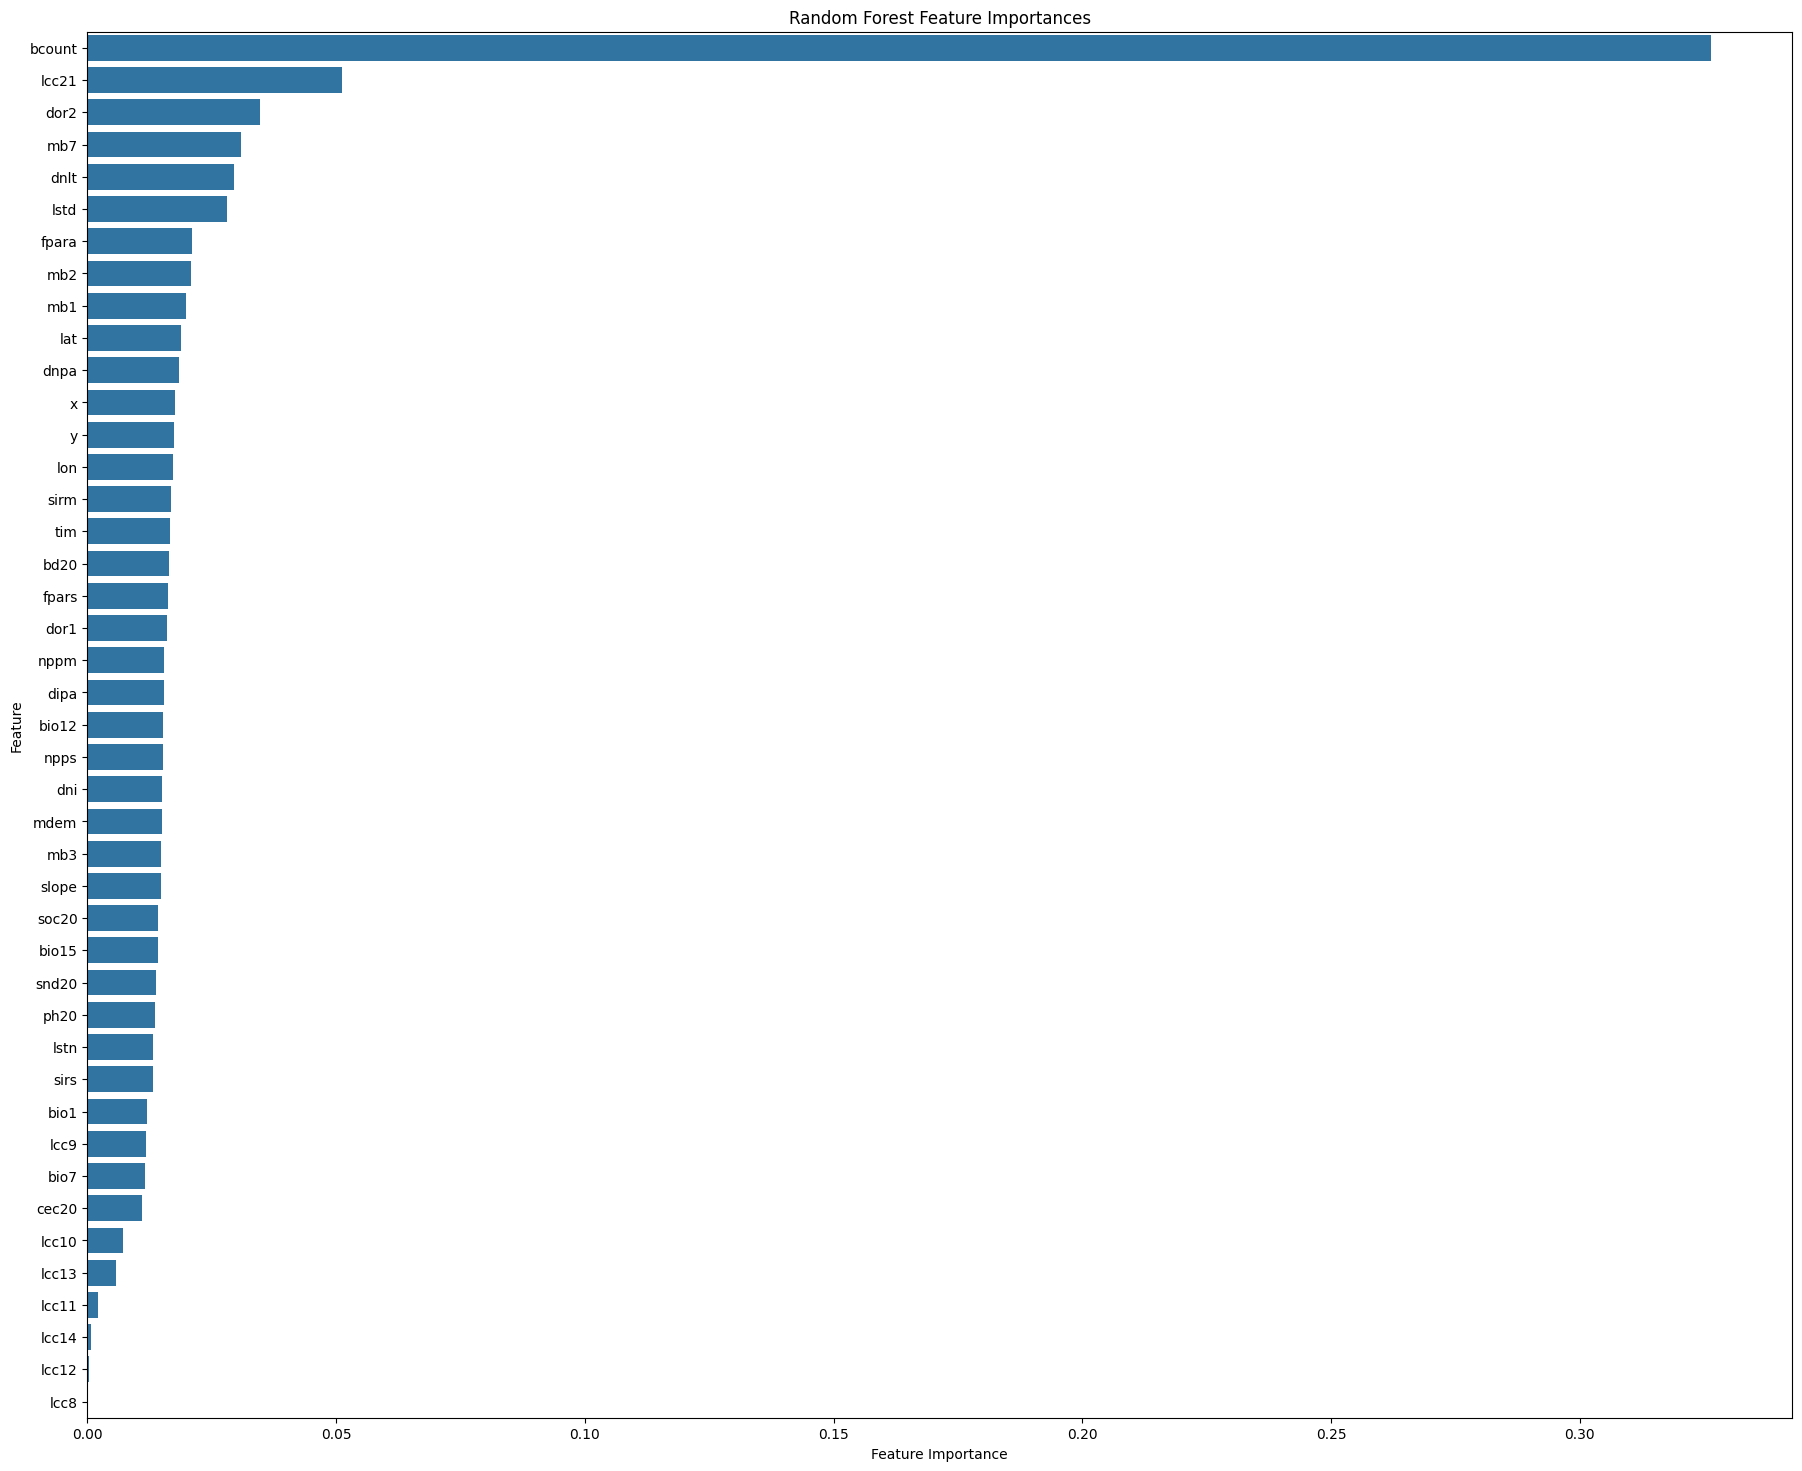

In [53]:
# Plot feature importances
plt.figure(figsize=(22, 18))
sns.barplot(y=feat_importances['Feature'], x=feat_importances['Importance'])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.show()

In [54]:
# Saving the model as a file
import joblib

# Save the tuned Random Forest model to a file
joblib.dump(rf_model_tuned, 'rf_model_tuned.pkl')

['rf_model_tuned.pkl']

In [55]:
#Preprocess test set features
X_test = test_gdf.drop(columns=['subid'])
X_test_scaled = scaler.transform(X_test)

In [56]:
# Generate predicted probabilities for each class
test_probs = rf_model_tuned.predict_proba(X_test_scaled)

In [57]:
# Create submission Dataframe
submission_df = pd.DataFrame({
    'subid': test_gdf['subid'],
    'building_prob': test_probs[:, 0],
    'cropland_prob': test_probs[:, 1],
    'wcover_prob': test_probs[:, 2]
})


In [58]:
submission_df.head()

,subid,building_prob,cropland_prob,wcover_prob
0,1548905,0.080000,0.536667,0.383333
1,1548829,0.053333,0.410000,0.536667
2,1548811,0.026667,0.186667,0.786667
3,1548806,0.126667,0.586667,0.286667
4,1548798,0.093333,0.643333,0.263333


In [59]:
# Save the submission dataframe as csv file
submission_df.to_csv('submission.csv', index=False)